# Text-Sentiment-Analysis-using-LSTM

<a href="https://colab.research.google.com/github/LuluW8071/Text-Sentiment-Analysis/blob/main/Text_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Download and Load the dataset

The dataset that the following script will download is a combination of the `Yelp Polarity Dataset` and the `IMDb Movie Dataset`. The `Yelp Polarity Dataset` has been preprocessed by selecting specific columns to create a dataset suitable for **sentiment analysis**. This preprocessed dataset has been merged with the `IMDb Movie Dataset`.

In [4]:
import gdown
import zipfile
import os

file_url = 'https://drive.google.com/uc?id=1Jp3D5gdxGrwa5dHbr4p-pECrD8wi7vik'
file_name = 'sentiment_dataset.zip'

# Download the file from Google Drive
gdown.download(file_url, file_name, quiet=False)
extract_dir = './dataset'

# Extract the zip file
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Remove the zip file after extraction
os.remove(file_name)
print("Files extracted successfully to:", extract_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1Jp3D5gdxGrwa5dHbr4p-pECrD8wi7vik
From (redirected): https://drive.google.com/uc?id=1Jp3D5gdxGrwa5dHbr4p-pECrD8wi7vik&confirm=t&uuid=f2aeefdf-eaf2-408a-a2dd-5d35c4dfbcd5
To: /content/sentiment_dataset.zip
100%|██████████| 182M/182M [00:01<00:00, 107MB/s]


Files extracted successfully to: ./dataset


In [5]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv("dataset/sentiment_combined.csv")
df.sample(5)

,review,sentiment
132407,Usually this is a good location. I actually dr...,negative
270911,"All Im gonna say is \""Bad place to have a Taek...",negative
585761,Pretty much echoing the same gripes as the oth...,negative
30243,I used to love watching this. I had no idea it...,positive
290934,I'm not normally this negative in reviews but ...,negative


## 2. Data Analysis

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

train data shape: (549000,)
test data shape: (61000,)


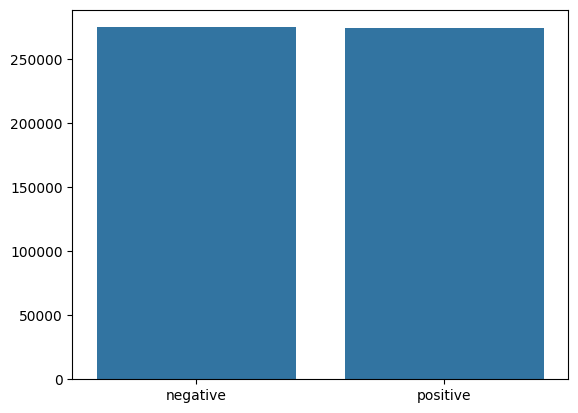

In [13]:
X, y = df['review'].values,df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.1)
print(f'train data shape: {X_train.shape}')
print(f'test data shape: {X_test.shape}')


val = pd.Series(y_train).value_counts()
sns.barplot(x = np.array(['negative','positive']),
            y = val.values)
plt.show()

## 3. Text Pre-Processing
- Cleaning up the text data by removing punctuation, extra spaces, and numbers.
- Transform sentences into individual words, remove common words (known as "stop words")
- Keeping track of the 1000 most frequently used words in the dataset
- Assigning tracked words a unique identifier, forming dictionary for one-hot encoding
- Ensuring all sequences have the same length by padding or truncating them as needed by 500 tokens

In [14]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Precompile regular expressions for faster pre processing [improved by 50% in preprocess]
non_word_chars_pattern = re.compile(r"[^\w\s]")
whitespace_pattern = re.compile(r"\s+")
digits_pattern = re.compile(r"\d")
username_pattern = re.compile(r"@([^\s]+)")
hashtags_pattern = re.compile(r"#\d+")

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = non_word_chars_pattern.sub('', s)
    # Replace all runs of whitespaces with single space
    s = whitespace_pattern.sub(' ', s)
    # Replace digits with no space
    s = digits_pattern.sub('', s)
    # Replace usernames with no space
    s = username_pattern.sub('', s)
    # Replace hashtags with no space
    s = hashtags_pattern.sub('', s)
    # Replace specific characters
    s = s.replace("https", "")
    s = s.replace("http", "")
    s = s.replace("rt", "")
    s = s.replace("-", "")
    # Replace <br /> with a space
    s = s.replace("<br />", " ")
    # Replace newline character with empty string
    s = s.replace("\n", "")
    return s

In [16]:
# Create a Tokenize including padding Function
def tokenize(X_train, y_train, X_val, y_val, seq_len):
    word_list = []
    stop_words = set(stopwords.words('english'))

    for sent in tqdm(X_train, desc="Preprocessing train data"):
        words = [preprocess_string(word) for word in sent.lower().split()]
        word_list.extend([word for word in words if word not in stop_words and word != ''])

    corpus = Counter(word_list)
    # Sorting on the basis of most common words
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    # Creating a dictionary
    onehot_dict = {w: i + 1 for i, w in enumerate(corpus_)}

    # Tokenize and pad sequences
    final_list_train = [[onehot_dict.get(preprocess_string(word), 0) for word in sent.lower().split() if preprocess_string(word) in onehot_dict]
                        for sent in tqdm(X_train, desc="Tokenizing and padding train data")]
    final_list_train = [padded_tokens[-seq_len:] if len(padded_tokens) > seq_len else [0] * (seq_len - len(padded_tokens)) + padded_tokens
                        for padded_tokens in final_list_train]

    final_list_test = [[onehot_dict.get(preprocess_string(word), 0) for word in sent.lower().split() if preprocess_string(word) in onehot_dict]
                       for sent in tqdm(X_val, desc="Tokenizing and padding validation data")]
    final_list_test = [padded_tokens[-seq_len:] if len(padded_tokens) > seq_len
                       else [0] * (seq_len - len(padded_tokens)) + padded_tokens
                       for padded_tokens in final_list_test]

    encoded_train = np.array([1 if label == 'positive' else 0 for label in y_train])
    encoded_test = np.array([1 if label == 'positive' else 0 for label in y_val])

    return np.array(final_list_train), encoded_train, np.array(final_list_test), encoded_test, onehot_dict

In [17]:
seq_len = 300
X_train, y_train, X_test, y_test, vocab = tokenize(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   seq_len)

len(X_train), len(X_test)

Tokenizing and padding validation data: 100%|██████████| 61000/61000 [00:32<00:00, 1893.55it/s]


(549000, 61000)

In [18]:
X_train, y_train

(array([[  0,   0,   0, ...,  87, 140,  54],
        [  0,   0,   0, ...,   8, 136, 943],
        [  0,   0,   0, ...,  28, 119,  67],
        ...,
        [  0,   0,   0, ..., 241,  22, 123],
        [  0,   0,   0, ..., 168, 242, 501],
        [  0,   0,   0, ...,  94, 162, 109]]),
 array([1, 0, 1, ..., 1, 1, 1]))

## 4. Preparing the data using DataLoader

In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [29]:
# Create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train),
                           torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_test),
                           torch.from_numpy(y_test))

BATCH_SIZE = 100

# Create train and valid dataloader
train_dataloader = DataLoader(train_data,
                              shuffle=True,
                              batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(valid_data,
                              shuffle=True,
                              batch_size=BATCH_SIZE)

len(train_dataloader), len(valid_dataloader)

(5490, 610)

In [30]:
# Sampling one bacth from train_dataloader
sample_data = iter(train_dataloader)
sample_x, sample_y = next(sample_data)

print('Sample input size:', sample_x.size())     # batch_size, seq_length
print('Sample input:', sample_x)
print('Sample output:', sample_y)

Sample input size: torch.Size([100, 300])
Sample input: tensor([[  0,   0,   0,  ...,  91,  70,   1],
        [  0,   0,   0,  ...,   2,  19,  85],
        [  0,   0,   0,  ..., 394, 134,  52],
        ...,
        [  0,   0,   0,  ..., 454, 892, 982],
        [  0,   0,   0,  ..., 230, 694, 208],
        [  0,   0,   0,  ...,   4, 271, 944]])
Sample output: tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 0, 0])


## 5. Building a LSTM Model

<img src = "assets/LSTM-Model.png">

In [31]:
import torch
from torch import nn
from torch.nn.utils import clip_grad_norm_

# Setting device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Here's a breakdown of how each component of the `SentimentLSTM` class processes the tokenized and padded array of text:

### Embedding Layer
The embedding layer (`self.embedding`) takes the tokenized and padded array of text as input. It converts each token (represented as an integer) into a dense vector of fixed size (`embedding_dim`). This dense representation captures semantic similarities between words. The input shape to the embedding layer is `(batch_size, sequence_length)`, where `batch_size` is the number of sequences in the batch and `sequence_length` is the length of each sequence.

### LSTM Layer
The LSTM layer (`self.lstm`) processes the embedded sequences over time. It takes the embedded input sequences and maintains hidden states to capture long-term dependencies. The LSTM layer consists of multiple LSTM units (determined by `no_layers`). Each LSTM unit processes one time step of the input sequence at a time. The input shape to the LSTM layer is `(batch_size, sequence_length, embedding_dim)`.

### Dropout Layer
The dropout layer (`self.dropout`) is applied after the LSTM layer. It helps prevent overfitting by randomly setting a fraction of input units to zero during training. This regularization technique improves the model's generalization performance. The input shape to the dropout layer is `(batch_size, sequence_length, hidden_dim)`.

### Fully Connected (Linear) Layer
The fully connected layer (`self.fc`) takes the output from the LSTM layer and transforms it into the desired output dimension (`output_dim`). It applies a linear transformation to the input data, followed by an optional bias term. The input shape to the fully connected layer is `(batch_size * sequence_length, hidden_dim)`.

### Sigmoid Activation Function
The sigmoid activation function (`self.sig`) is applied to the output of the fully connected layer. It squashes the output values to the range [0, 1], interpreting them as probabilities. In sentiment analysis, this allows the model to predict the probability of a given input belonging to a particular sentiment class (e.g., positive or negative). The output shape after applying the sigmoid function is `(batch_size * sequence_length)`.

In [32]:
class SentimentLSTM(nn.Module):
  def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim = 1):
    super(SentimentLSTM, self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.vocab_size = vocab_size

    # Embedding and LSTM layers
    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # LSTM Layer
    self.lstm = nn.LSTM(input_size = embedding_dim,
                        hidden_size = self.hidden_dim,
                        num_layers = no_layers,
                        batch_first = True)

    self.dropout = nn.Dropout(0.3)                    # Dropout Layer
    self.fc = nn.Linear(self.hidden_dim, output_dim)  # Linear Layer
    self.sig = nn.Sigmoid()                           # Sigmoid Activation Function

  def forward(self, x, hidden):
    """ Forward pass """
    batch_size = x.size(0)

    # Embeddings and lstm_out
    embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
    # print(embeds.shape)
    lstm_out, hidden = self.lstm(embeds, hidden)
    lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

    out = self.dropout(lstm_out)            # Dropout
    out = self.fc(out)                      # Fully connected layer

    sig_out = self.sig(out)                 # sigmoid function
    sig_out = sig_out.view(batch_size, -1)  # Reshape to be batch_size first
    sig_out = sig_out[:, -1]                # get last batch of labels
    return sig_out, hidden                  # return last sigmoid output and hidden state

  def init_hidden(self, batch_size):
    """ Initializes hidden state """
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # Initialized to zero, for hidden state and cell state of LSTM
    hidden_state = torch.zeros((self.no_layers,
                                batch_size,
                                self.hidden_dim)).to(device)
    # print(batch_size)
    cell_state = torch.zeros((self.no_layers,
                              batch_size,
                              self.hidden_dim)).to(device)
    hidden = (hidden_state, cell_state)
    # print("Hidden", hidden_state.size())
    # print("Cell", cell_state.size())
    return hidden

In [33]:
model = SentimentLSTM(no_layers = 2,               # LSTM doesn't perform quite well beyound 2 layers
                      vocab_size = len(vocab) + 1, # 1 extra for padding
                      hidden_dim = 256,
                      embedding_dim = 64)

# Pass model to device 'cuda' if selected
model.to(device)

SentimentLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

## 6. Create Train and Validation Loop Function

In [34]:
# Function to predict accuracy
def acc(pred, label):
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()

In [35]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs, clip, device):
  valid_loss_min = np.Inf
  epoch_tr_loss, epoch_vl_loss = [], []
  epoch_tr_acc, epoch_vl_acc = [], []

  for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()

    # Initialize hidden state
    h = model.init_hidden(BATCH_SIZE)

    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      # Creating new variables for the hidden state to prevent backpropagation
      # through the entire training history
      h = tuple([each.data for each in h])

      optimizer.zero_grad()
      output, h = model(inputs, h)
      loss = criterion(output.squeeze(), labels.float())
      loss.backward()

      train_losses.append(loss.item())
      accuracy = acc(output, labels)
      train_acc += accuracy
      clip_grad_norm_(model.parameters(), clip)
      optimizer.step()

    val_h = model.init_hidden(BATCH_SIZE)
    val_losses = []
    val_acc = 0.0
    model.eval()

    for inputs, labels in valid_loader:
      val_h = tuple([each.data for each in val_h])
      inputs, labels = inputs.to(device), labels.to(device)
      output, val_h = model(inputs, val_h)
      val_loss = criterion(output.squeeze(), labels.float())
      val_losses.append(val_loss.item())
      accuracy = acc(output, labels)
      val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    print(f'Epoch: {epoch+1} -- train_loss: {epoch_train_loss:.4f} -- train_acc: {epoch_train_acc*100:.2f}% -- val_loss: {epoch_val_loss:.4f} -- val_acc: {epoch_val_acc*100:.2f}%')

    # Saving model on each epoch except when valid_loss_for_next_epoch > valid_loss_for_prev_epoch
    if epoch_val_loss <= valid_loss_min:
      torch.save(model.state_dict(), 'sentiment_model.pth')
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, epoch_val_loss))
      valid_loss_min = epoch_val_loss
    print(25*'==')

  return epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc

## 7. Train and Evaluate the Model

In [36]:
# Loss function and Optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [37]:
train_losses, val_losses, train_accs, val_accs = train_model(model = model,
                                                             train_loader = train_dataloader,
                                                             valid_loader = valid_dataloader,
                                                             criterion = loss_fn,
                                                             optimizer = optimizer,
                                                             epochs = 5,
                                                             clip = 5,
                                                             device = device)

Epoch: 1 -- train_loss: 0.2746 -- train_acc: 88.19% -- val_loss: 0.2382 -- val_acc: 89.73%
Validation loss decreased (inf --> 0.238167).  Saving model ...
Epoch: 2 -- train_loss: 0.2183 -- train_acc: 90.86% -- val_loss: 0.2181 -- val_acc: 90.74%
Validation loss decreased (0.238167 --> 0.218082).  Saving model ...
Epoch: 3 -- train_loss: 0.1921 -- train_acc: 92.05% -- val_loss: 0.2105 -- val_acc: 91.15%
Validation loss decreased (0.218082 --> 0.210509).  Saving model ...
Epoch: 4 -- train_loss: 0.1653 -- train_acc: 93.20% -- val_loss: 0.2177 -- val_acc: 90.97%
Epoch: 5 -- train_loss: 0.1376 -- train_acc: 94.41% -- val_loss: 0.2393 -- val_acc: 90.85%


## 8. Plot Loss and Accuracy Curves

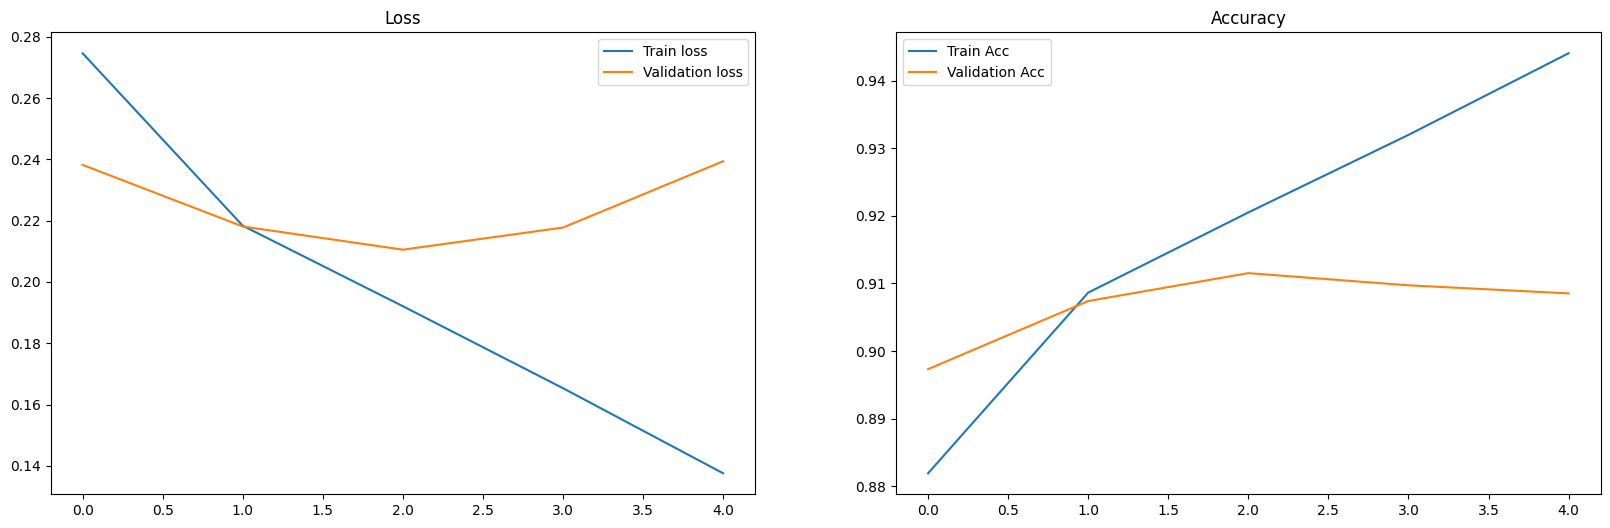

In [38]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Validation Acc')
plt.title("Accuracy")
plt.legend()

plt.show()

## 9. Load Model to `cpu`

In [39]:
# Load model configs
model = SentimentLSTM(no_layers = 2,
                      vocab_size = len(vocab) + 1,
                      hidden_dim = 256,
                      embedding_dim = 64)

# Load the model state dict
model.load_state_dict(torch.load("sentiment_model.pth", map_location=device))

# Move the model to CPU
model.to('cpu')

SentimentLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

## 10. Make Prediction using Loaded Model

In [109]:
def padding_(seq, max_length):
    """Pad sequences to the same length"""
    if len(seq) >= max_length:
        return seq[:max_length]
    else:
        padded = np.zeros((seq.shape[0], max_length), dtype=int)
        padded[:, :seq.shape[1]] = seq
        return padded

def predict_text(text):
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq, axis=0)
    pad = torch.from_numpy(padding_(word_seq, 300))
    inputs = pad.to('cpu')  # Move inputs to CPU
    batch_size = 1
    h = model.init_hidden(batch_size)
    # Move the initial hidden state to CPU
    h = tuple([each.to('cpu') for each in h])
    # Set to evaluation mode
    with torch.inference_mode():
        output, h = model(inputs, h)
    return output.item()

In [117]:
import random

# Randomly select 5 index from dataset to predict
for _ in range(5):
    index = random.randint(0, 550000)
    review = df['review'][index]
    actual_sentiment = df['sentiment'][index]

    print("Review:")
    print(review)
    print('='*70)
    print(f'Actual sentiment: {actual_sentiment}')
    print('='*70)
    pro = predict_text(review)
    predicted_sentiment = "positive" if pro > 0.45 else "negative"
    pro = (1 - pro) if predicted_sentiment == "negative" else pro

    # Color-coding output based on prediction matching actual sentiment
    if actual_sentiment == predicted_sentiment:
        color = '\033[92m'  # Green color for matching sentiment
    else:
        color = '\033[91m'  # Red color for mismatching sentiment

    print(f'Predicted sentiment: {color}{predicted_sentiment}\033[0m with a probability of {pro * 100:.2f}%')
    print('='*70)

Review:
A very good place all around.  The service is quick, prices are reasonable and the food quality is very good.\n\nThey even have a drive-thru which is super-fast and convenient.  I've even ordered for 8-10 people at the drive-thru and it's quick.\n\nThe cheesy biscuits are great, as are the baked beans.  Salads pretty good too.  I would give them a 4.5 if I could.  I'm stingy with my 5's, but this is a strong 4.  You won't go wrong here.\n\nYes it's a small chain, but it doesn't feel like a chain.
Actual sentiment: positive
Predicted sentiment: positive with a probability of 46.31%
Review:
You have got to be kidding! As if Las Vegas needs any more contributions to it's notable lack of culture, authenticity and overall blandness. Here you have a place that is touting a new kind of BBQ, \"Las Vegas Style\". Now if by saying \"Vegas Style BBQ\" means that nothing that you do is actually barbecued, then Sassy Sal's has accomplished great things. Now I know that I'm sounding a bit li

In [112]:
def predict_custom_text(custom_text):
  pro = predict_text(custom_text)
  status = "positive" if pro > 0.45 else "negative"
  pro = (1 - pro) if status == "negative" else pro
  print(f'Predicted: {status} \nProbability {pro*100 :.2f}%')

In [115]:
# Custom Negative Text
custom_text = "I can't even begin to express my sheer frustration and utter disappointment with this product! It's an absolute disaster from start to finish. "
predict_custom_text(custom_text)

Predicted: negative 
Probability 55.82%


In [116]:
# Custom Positive Text
custom_text = "I recently watched a movie that completely exceeded my expectations. From the captivating storyline to the stellar performances of the cast, every aspect of the film was a delight. The characters were well-developed and relatable, each with their own unique charm that drew me into their world. The dialogue was witty and engaging, keeping me entertained from start to finish. Additionally, the stunning visuals and masterful cinematography added depth and richness to the viewing experience. Overall, it was a cinematic masterpiece that left me feeling uplifted and inspired. I highly recommend this movie to anyone looking for a heartwarming and enjoyable film."
predict_custom_text(custom_text)

Predicted: positive 
Probability 47.16%


In [127]:
i = [123, 345, 456, 678, 88888]

for i in range(len(i)):
  custom_text = df["review"][i]
  print("\nContext:", df["review"][i])
  print("Actual:", df["sentiment"][i])
  predict_custom_text(custom_text)


Context: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due 